In [1]:
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from time import time
import sklearn.preprocessing
import numpy as np
import robust_onlinehd
from GenAttack import GenAttack

In [2]:
scaler = sklearn.preprocessing.Normalizer()

In [3]:
torch.manual_seed(54)

In [4]:

# loads simple mnist dataset
def load():  
    (x, y), (x_test, y_test) = fashion_mnist.load_data()

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()   
    y = torch.from_numpy(y).long().squeeze()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()
    
    if len(x.shape) == 3:
        x = x.unsqueeze(3)
        x_test = x_test.unsqueeze(3)

    return x, x_test, y, y_test


print('Loading...')
x, x_test, y, y_test = load()

Loading...


<ipython-input-4-84a179f8522e>:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()


In [5]:
#criterias = [(0, 100, 0), (100, 150, 125), (150, 200, 175), (200, 256, 255)]
criterias = [(0, 50, 0), (50, 100, 75), (100, 125, 124), (125, 150, 149), (150, 175, 174), (175, 200, 199), (200, 225, 224), (225, 256, 255)]
#criterias = []
#kernel_size = 3
kernel_size = 1
classes = y.unique().size(0)
features = x.size(1) * x.size(2)
model = robust_onlinehd.OnlineHD(criterias, kernel_size, scaler, classes, features, dim = 10000)


if torch.cuda.is_available():
    #x = x.cuda()
    #y = y.cuda()
    #x_test = x_test.cuda()
    #y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()

model = model.fit(x, y, bootstrap=.3, lr=0.095, epochs=300, batch_size=8196)
t = time() - t

print('Validating...')
yhat = model(x).cpu()
yhat_test = model(x_test).cpu()
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')


In [ ]:
preds = model(x_test).cpu().numpy()
#preds = model(x).cpu().numpy()

In [ ]:
targets = torch.randint(0, 10, preds.shape)
for i in tqdm(range(len(preds))):
    while targets[i] == preds[i]:
        targets[i] = torch.randint(0,10, (1,)).item()

100%|██████████| 10000/10000 [00:00<00:00, 52695.64it/s]


In [ ]:
unif = torch.ones(targets.shape[0])
while True:
    indices = unif.multinomial(100)
    for idx in indices:
        if targets[idx] == y_test[idx]:
            break
    if idx == indices[-1] and targets[idx] != y_test[idx]:
        break
    else:
        indices = unif.multinomial(100)

In [ ]:
attacker = GenAttack(model, classes, 28 * 28, scaler, 0.6, 'cuda')
N = 8                          # size of population to evolve
G = 5000                        # number of generations to evolve through
p = torch.FloatTensor([0.9])   # the parameter for Bernoulli distribution used in mutation
alpha = torch.FloatTensor([1.0]) # the parameter controlling mutation amount (step-size in the original paper)
delta = torch.FloatTensor([0.9]) # the parametr controlling mutation amount (norm threshold in the original paper)

In [ ]:
pops = []
results = []

In [ ]:
t = time()
for i in tqdm(indices):
    temp = attacker.attack(x_test[i], targets[i], delta, alpha, p, N, G)
    pops.append(temp[0].numpy())
    results.append(temp[1])
t = time() - t

print(f'{t = :6f}')

  1%|          | 1/100 [02:00<3:18:04, 120.05s/it]

All 5000 generations failed.


  2%|▏         | 2/100 [04:20<3:35:31, 131.95s/it]

All 5000 generations failed.


  3%|▎         | 3/100 [06:40<3:39:13, 135.60s/it]

All 5000 generations failed.


  4%|▍         | 4/100 [07:15<2:33:27, 95.91s/it] 

Attack Success at generation 1253


  5%|▌         | 5/100 [09:35<2:56:56, 111.75s/it]

All 5000 generations failed.


  6%|▌         | 6/100 [11:55<3:10:17, 121.46s/it]

All 5000 generations failed.


  7%|▋         | 7/100 [14:15<3:17:40, 127.54s/it]

All 5000 generations failed.


  8%|▊         | 8/100 [16:35<3:21:50, 131.64s/it]

All 5000 generations failed.


  9%|▉         | 9/100 [16:48<2:23:19, 94.50s/it] 

Attack Success at generation 458


 10%|█         | 10/100 [19:09<2:43:00, 108.67s/it]

All 5000 generations failed.


 11%|█         | 11/100 [21:29<2:55:38, 118.40s/it]

All 5000 generations failed.


 12%|█▏        | 12/100 [23:50<3:03:42, 125.26s/it]

All 5000 generations failed.


 13%|█▎        | 13/100 [26:10<3:08:13, 129.81s/it]

All 5000 generations failed.


 14%|█▍        | 14/100 [28:31<3:10:40, 133.03s/it]

All 5000 generations failed.


 15%|█▌        | 15/100 [30:52<3:11:46, 135.37s/it]

All 5000 generations failed.


 16%|█▌        | 16/100 [31:08<2:19:09, 99.40s/it] 

Attack Success at generation 566


 17%|█▋        | 17/100 [33:28<2:34:32, 111.72s/it]

All 5000 generations failed.


 18%|█▊        | 18/100 [35:48<2:44:24, 120.30s/it]

All 5000 generations failed.


 19%|█▉        | 19/100 [36:15<2:04:32, 92.25s/it] 

Attack Success at generation 961


 20%|██        | 20/100 [38:35<2:22:12, 106.66s/it]

All 5000 generations failed.


 21%|██        | 21/100 [40:56<2:33:43, 116.75s/it]

All 5000 generations failed.


 22%|██▏       | 22/100 [43:16<2:41:06, 123.93s/it]

All 5000 generations failed.


 23%|██▎       | 23/100 [45:36<2:45:11, 128.72s/it]

All 5000 generations failed.


 24%|██▍       | 24/100 [45:37<1:54:16, 90.22s/it] 

Attack Success at generation 14


 25%|██▌       | 25/100 [47:57<2:11:39, 105.33s/it]

All 5000 generations failed.


 26%|██▌       | 26/100 [50:18<2:22:57, 115.91s/it]

All 5000 generations failed.


 27%|██▋       | 27/100 [52:38<2:30:00, 123.29s/it]

All 5000 generations failed.


 28%|██▊       | 28/100 [54:59<2:34:06, 128.42s/it]

All 5000 generations failed.


 29%|██▉       | 29/100 [57:19<2:36:06, 131.93s/it]

All 5000 generations failed.


 30%|███       | 30/100 [59:25<2:31:45, 130.08s/it]

All candidates died at generation 4463
Target =  tensor(1, device='cuda:0')


 31%|███       | 31/100 [59:36<1:48:49, 94.64s/it] 

Attack Success at generation 423


 32%|███▏      | 32/100 [1:01:57<2:02:44, 108.31s/it]

All 5000 generations failed.


 33%|███▎      | 33/100 [1:04:16<2:11:20, 117.62s/it]

All 5000 generations failed.


 34%|███▍      | 34/100 [1:06:35<2:16:34, 124.17s/it]

All 5000 generations failed.


 35%|███▌      | 35/100 [1:08:56<2:19:45, 129.01s/it]

All 5000 generations failed.


 36%|███▌      | 36/100 [1:11:16<2:21:19, 132.50s/it]

All 5000 generations failed.


 37%|███▋      | 37/100 [1:13:37<2:21:38, 134.90s/it]

All 5000 generations failed.


 38%|███▊      | 38/100 [1:15:57<2:21:06, 136.55s/it]

All 5000 generations failed.


 39%|███▉      | 39/100 [1:18:17<2:19:56, 137.64s/it]

All 5000 generations failed.


 40%|████      | 40/100 [1:20:37<2:18:20, 138.34s/it]

All 5000 generations failed.


 41%|████      | 41/100 [1:22:58<2:16:32, 138.85s/it]

All 5000 generations failed.


 42%|████▏     | 42/100 [1:25:18<2:14:42, 139.35s/it]

All 5000 generations failed.


 43%|████▎     | 43/100 [1:25:20<1:33:07, 98.02s/it] 

Attack Success at generation 56


 44%|████▍     | 44/100 [1:25:35<1:08:16, 73.16s/it]

Attack Success at generation 539


 45%|████▌     | 45/100 [1:27:55<1:25:26, 93.21s/it]

All 5000 generations failed.


 46%|████▌     | 46/100 [1:30:16<1:36:44, 107.49s/it]

All 5000 generations failed.


 47%|████▋     | 47/100 [1:32:36<1:43:37, 117.30s/it]

All 5000 generations failed.


 48%|████▊     | 48/100 [1:34:56<1:47:37, 124.17s/it]

All 5000 generations failed.


 49%|████▉     | 49/100 [1:37:16<1:49:31, 128.86s/it]

All 5000 generations failed.


 50%|█████     | 50/100 [1:39:36<1:50:17, 132.35s/it]

All 5000 generations failed.


 51%|█████     | 51/100 [1:41:57<1:50:08, 134.86s/it]

All 5000 generations failed.


 52%|█████▏    | 52/100 [1:41:58<1:15:43, 94.66s/it] 

Attack Success at generation 30


 53%|█████▎    | 53/100 [1:44:18<1:24:51, 108.33s/it]

All 5000 generations failed.


 54%|█████▍    | 54/100 [1:46:38<1:30:20, 117.83s/it]

All 5000 generations failed.


 55%|█████▌    | 55/100 [1:48:58<1:33:23, 124.52s/it]

All 5000 generations failed.


 56%|█████▌    | 56/100 [1:51:18<1:34:46, 129.24s/it]

All 5000 generations failed.


 57%|█████▋    | 57/100 [1:51:19<1:04:55, 90.60s/it] 

Attack Success at generation 15


 58%|█████▊    | 58/100 [1:53:39<1:13:48, 105.45s/it]

All 5000 generations failed.


 59%|█████▉    | 59/100 [1:55:59<1:19:14, 115.95s/it]

All 5000 generations failed.


 60%|██████    | 60/100 [1:58:20<1:22:13, 123.34s/it]

All 5000 generations failed.


 61%|██████    | 61/100 [2:00:40<1:23:29, 128.44s/it]

All 5000 generations failed.


 62%|██████▏   | 62/100 [2:03:01<1:23:35, 131.99s/it]

All 5000 generations failed.


 63%|██████▎   | 63/100 [2:05:21<1:22:57, 134.53s/it]

All 5000 generations failed.


 64%|██████▍   | 64/100 [2:07:41<1:21:45, 136.27s/it]

All 5000 generations failed.


 65%|██████▌   | 65/100 [2:10:02<1:20:09, 137.42s/it]

All 5000 generations failed.


 66%|██████▌   | 66/100 [2:12:22<1:18:21, 138.29s/it]

All 5000 generations failed.


 67%|██████▋   | 67/100 [2:14:42<1:16:21, 138.83s/it]

All 5000 generations failed.


 68%|██████▊   | 68/100 [2:17:01<1:14:08, 139.01s/it]

All 5000 generations failed.


 69%|██████▉   | 69/100 [2:19:22<1:12:03, 139.47s/it]

All 5000 generations failed.


 70%|███████   | 70/100 [2:21:42<1:09:51, 139.73s/it]

All 5000 generations failed.


 71%|███████   | 71/100 [2:24:03<1:07:39, 139.97s/it]

All 5000 generations failed.


 72%|███████▏  | 72/100 [2:26:23<1:05:21, 140.07s/it]

All 5000 generations failed.


 73%|███████▎  | 73/100 [2:28:43<1:03:02, 140.10s/it]

All 5000 generations failed.


 74%|███████▍  | 74/100 [2:31:04<1:00:45, 140.22s/it]

All 5000 generations failed.


 75%|███████▌  | 75/100 [2:33:24<58:25, 140.22s/it]  

All 5000 generations failed.


 76%|███████▌  | 76/100 [2:35:45<56:08, 140.37s/it]

All 5000 generations failed.


 77%|███████▋  | 77/100 [2:38:05<53:45, 140.25s/it]

All 5000 generations failed.


 78%|███████▊  | 78/100 [2:40:25<51:26, 140.31s/it]

All 5000 generations failed.


 79%|███████▉  | 79/100 [2:42:46<49:07, 140.37s/it]

All 5000 generations failed.


 80%|████████  | 80/100 [2:45:06<46:47, 140.38s/it]

All 5000 generations failed.


 81%|████████  | 81/100 [2:45:14<31:55, 100.80s/it]

Attack Success at generation 301


 82%|████████▏ | 82/100 [2:47:35<33:48, 112.68s/it]

All 5000 generations failed.


 83%|████████▎ | 83/100 [2:49:56<34:20, 121.21s/it]

All 5000 generations failed.


 84%|████████▍ | 84/100 [2:52:17<33:52, 127.06s/it]

All 5000 generations failed.


 85%|████████▌ | 85/100 [2:54:37<32:45, 131.05s/it]

All 5000 generations failed.


 86%|████████▌ | 86/100 [2:56:57<31:13, 133.81s/it]

All 5000 generations failed.


 87%|████████▋ | 87/100 [2:59:18<29:26, 135.85s/it]

All 5000 generations failed.


 88%|████████▊ | 88/100 [3:01:38<27:27, 137.26s/it]

All 5000 generations failed.


 89%|████████▉ | 89/100 [3:03:59<25:20, 138.20s/it]

All 5000 generations failed.


 90%|█████████ | 90/100 [3:04:13<16:49, 100.94s/it]

Attack Success at generation 502


 91%|█████████ | 91/100 [3:06:33<16:54, 112.69s/it]

All 5000 generations failed.


 92%|█████████▏| 92/100 [3:08:53<16:06, 120.81s/it]

All 5000 generations failed.


 93%|█████████▎| 93/100 [3:11:13<14:46, 126.65s/it]

All 5000 generations failed.


 94%|█████████▍| 94/100 [3:13:33<13:04, 130.79s/it]

All 5000 generations failed.


 95%|█████████▌| 95/100 [3:15:54<11:08, 133.65s/it]

All 5000 generations failed.


 96%|█████████▌| 96/100 [3:18:14<09:02, 135.63s/it]

All 5000 generations failed.


 97%|█████████▋| 97/100 [3:20:35<06:51, 137.17s/it]

All 5000 generations failed.


 98%|█████████▊| 98/100 [3:22:56<04:36, 138.29s/it]

All 5000 generations failed.


 99%|█████████▉| 99/100 [3:23:39<01:49, 109.71s/it]

Attack Success at generation 1529


100%|██████████| 100/100 [3:25:58<00:00, 123.59s/it]

All 5000 generations failed.
t = 12358.982374


In [ ]:
pops = np.array(pops)

In [ ]:
sample_preds = preds[indices]

In [ ]:
new_preds = []
for i in range(100):
    new_preds.append(model(torch.tensor(pops[i])).cpu().numpy())

In [ ]:
success = 0
success_idx = []
for i in range(100):
    if targets[indices[i]].item() in new_preds[i]:
        success_idx.append((indices[i].item(), (i, np.where(new_preds[i] == targets[indices[i]].item())[0][0])))
        success += 1
print(success)

13


In [ ]:
cache = {
    'indices' : indices,
    'sample_preds' : sample_preds,
    'pops' : np.array(pops),
    'hyper_parameter' : [N, G, p, alpha, delta],
    'success_idx' : success_idx,
    'model' : model, 
    'scaler' : model.scaler,
    'targets' : targets,
    'results' : results
}

In [ ]:
torch.save(cache, 'robust_onlinehd_fashion_mnist.pt')

In [ ]:
model(torch.tensor(pops[0]))

tensor([7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')

In [ ]:
labels = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

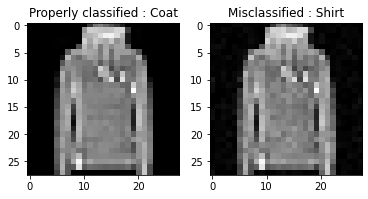

In [ ]:
origin_idx, (new_idx, new_idx_idx) = success_idx[torch.randint(0, len(success_idx), (1,)).item()]

f, axes = plt.subplots(1, 2)
axes[0].imshow(x_test[origin_idx], cmap=plt.gray())
_ = axes[0].set_title('Properly classified : %s' % labels[sample_preds[new_idx].item()])
axes[1].imshow(pops[new_idx][new_idx_idx].astype(np.int32))
_ = axes[1].set_title('Misclassified : %s' % labels[new_preds[new_idx][new_idx_idx]])